In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import financial.data as fd
import financial.model as fm
import financial.portfolio as fp
import financial.strategies.simulation as fss
from financial.io.file.cache import FileCache
from financial.io.cache import AppendStrategy
from financial.io.file.model import FileModelProvider
from financial.io.cache import NoUpdateStrategy

import os
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory

In [139]:
load_dotenv(dotenv_path=find_dotenv())

cache = os.environ["CACHE"] + "/"
model = os.environ["MODEL"]

ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))
mp = FileModelProvider(model_path=model)
mc = fm.ModelCache(ds, mp, cache=FileCache(update_strategy=AppendStrategy(), cache_path=model))
uc = fm.UnifiedCache(ds, mc)

In [140]:
from financial.momentum.indicators.modelIndicator import ModelIndicator
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#simulation_indicator = ModelIndicator("keras_cnn")
#import tensorflow as tf
#tf.keras.backend.clear_session()

from financial.momentum.indicators.kerasIndicator import KerasIndicator
simulation_indicator = KerasIndicator("cnn")

In [141]:
simulation_universe = ['BLK', '^IBEX', 'BAM', '^IXIC', 'GOOG', 'TSLA']
#simulation_universe = ['AAPL']
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

simulation_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=4), fsf.MinimumValueAssetFilter(threshold=0.0)] )
simulation_allocation = fsa.EqualWeightAllocation()
simulation_strategy = fsr.AssetRankingStrategy("Simulation", simulation_universe, simulation_indicator, simulation_filter, simulation_allocation)
print(simulation_strategy)

Simulation
- 6 asset universe: ['BLK', '^IBEX', 'BAM', '^IXIC', 'GOOG', 'TSLA']
- Indicator: {'type': 'financial.momentum.indicators.kerasIndicator.KerasIndicator', 'model': 'cnn'}


In [142]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy_simulation = "simulation"
strategy = simulation_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(-1,market) # +1 first day, -1 last day, +2 second day with 1st day momentum

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)

simulation = fss.StockStrategySimulation(uc, strategy, rebalancing, market)
simulation.verbose = True  # verbose 41.7s vs. 27s without trading details
simulation_start_year = 2016
simulation_end_year = 2024
simulation.simulate(start_year=simulation_start_year, end_year=simulation_end_year)

STRATEGY
Simulation
- 6 asset universe: ['BLK', '^IBEX', 'BAM', '^IXIC', 'GOOG', 'TSLA']
- Indicator: {'type': 'financial.momentum.indicators.kerasIndicator.KerasIndicator', 'model': 'cnn'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on -1
INITIAL PORTFOLIO
Stocks: ['$$$']
Portfolio value: 1000000.00
Portfolio assets: {'$$$': 1000000.0}
Portfolio stocks: {'$$$': 1000000}
Portfolio weights: {'$$$': 1.0}
+ Rebalance @ 2016-01-28
- Portfolio value: $1000000.00
{'^IBEX': 0.25, '^IXIC': 0.25, 'BLK': 0.25, 'GOOG': 0.25}
+ Trade @ 2016-01-29
<class 'numpy.float64'>
4202.065818786621
- Changes: {'^IXIC': 54, 'GOOG': 6729, '^IBEX': 28, 'BLK': 795, '$$$': -995797.9341812134}
- Rotation: 99.58%
Before $1000000.00:
- Stocks: {'$$$': 1000000}
- Assets: {'$$$': 1000000.0}
Selling $$$: -995797.93x$1.00 = $-995797.93
Buying ^IXIC: 54.00x$4613.95 = $249153.31
Buying GOOG: 6729.00x$37.15 = $249965.52
Buying ^IBEX: 28.00x$8815.80 = $246842.39
Buying BLK: 795.00x$314.26 = 

In [143]:
year_returns = simulation.year_returns()

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2016:  12.91%
2017:  27.10%
2018: -10.11%
2019:  26.93%
2020:  54.10%
2021:  28.55%
2022: -31.44%
2023:  45.67%
2024:  28.59%

CUMULATIVE RETURNS
2016:  12.91%
2017:  43.51%
2018:  29.00%
2019:  63.74%
2020: 152.32%
2021: 224.37%
2022: 122.39%
2023: 223.96%
2024: 316.58%


In [144]:
import financial.portfolios.statistics as fps
assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
benchmark_returns = target.returns(ds,'2010-12-31','2024-12-31')
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2010,2024)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)

In [145]:
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,simulation_start_year,simulation_end_year)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
fss.SimulationReport.simulation_report(benchmark_monthly_returns, fss.accumulate_return)

          TOTAL     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:    9.54%    9.54%  -5.07%  -0.41%   6.60%   0.27%   1.53%   0.09%   3.56%  -0.12%  -0.12%  -1.94%   3.42%   1.82%
  2017:   30.81%   19.42%   1.79%   3.72%  -0.04%   0.91%   1.16%   0.48%   1.93%   0.05%   1.93%   2.22%   2.81%   0.98%
  2018:   22.65%   -6.24%   5.62%  -3.89%  -2.69%   0.27%   2.16%   0.48%   3.60%   3.03%   0.43%  -6.94%   1.79%  -9.18%
  2019:   58.07%   28.88%   7.87%   2.97%   1.79%   3.93%  -6.58%   6.89%   1.31%  -1.81%   1.72%   2.04%   3.40%   2.86%
  2020:   83.77%   16.26%  -0.16%  -8.41% -12.51%  12.68%   4.53%   1.84%   5.51%   7.01%  -3.92%  -2.77%  10.75%   3.71%
  2021:  133.19%   26.89%  -1.11%   2.61%   4.24%   5.24%   0.55%   2.22%   2.27%   2.90%  -4.76%   6.91%  -0.83%   4.36%
  2022:   87.85%  -19.44%  -5.26%  -3.14%   3.58%  -8.80%   0.01%  -8.39%   9.11%  -4.24%  -9.34%   7.99%   5.38%  -5.90%
  2023:  133.36%   24.23%

In [146]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation: {100*rotation:.2f}%")

Average monthly rotation: 3.60%


In [147]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2016:  12.91%
2017:  27.10%
2018: -10.11%
2019:  26.93%
2020:  54.10%
2021:  28.55%
2022: -31.44%
2023:  45.67%
2024:  28.59%

CUMULATIVE RETURNS
2016:  12.91%
2017:  43.51%
2018:  29.00%
2019:  63.74%
2020: 152.32%
2021: 224.37%
2022: 122.39%
2023: 223.96%
2024: 316.58%


In [148]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
#print(monthly_returns)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:            12.91%   0.00%  -3.00%   6.66%  -0.23%   2.99%  -5.70%   7.41%   1.16%   0.29%  -0.78%   0.70%   3.43%
Monthly cumulative returns
  2016:            12.91%   0.00%  -3.00%   3.46%   3.23%   6.31%   0.26%   7.69%   8.94%   9.26%   8.41%   9.17%  12.91%

SERIES
Monthly returns
2016-01-31    0.000000
2016-02-29   -0.029977
2016-03-31    0.066602
2016-04-30   -0.002291
2016-05-31    0.029913
                ...   
2024-08-31   -0.002911
2024-09-30    0.084456
2024-10-31   -0.008271
2024-11-30    0.117119
2024-12-31    0.043281
Length: 108, dtype: float64
Cumulative returns
2016-01-31    0.000000
2016-02-29   -0.029977
2016-03-31    0.034629
2016-04-30    0.032259
2016-05-31    0.063137
                ...   
2024-08-31    2.323486
2024-09-30    2.604175
2024-10-31    2.574364
2024-11-30    2.992989
2024-12-31    3.165810
Length: 108, dtype: float64
CPU times: user 4.03 s, sys: 0 ns, total: 4.03 s
Wall time: 4.02 s


<Axes: >

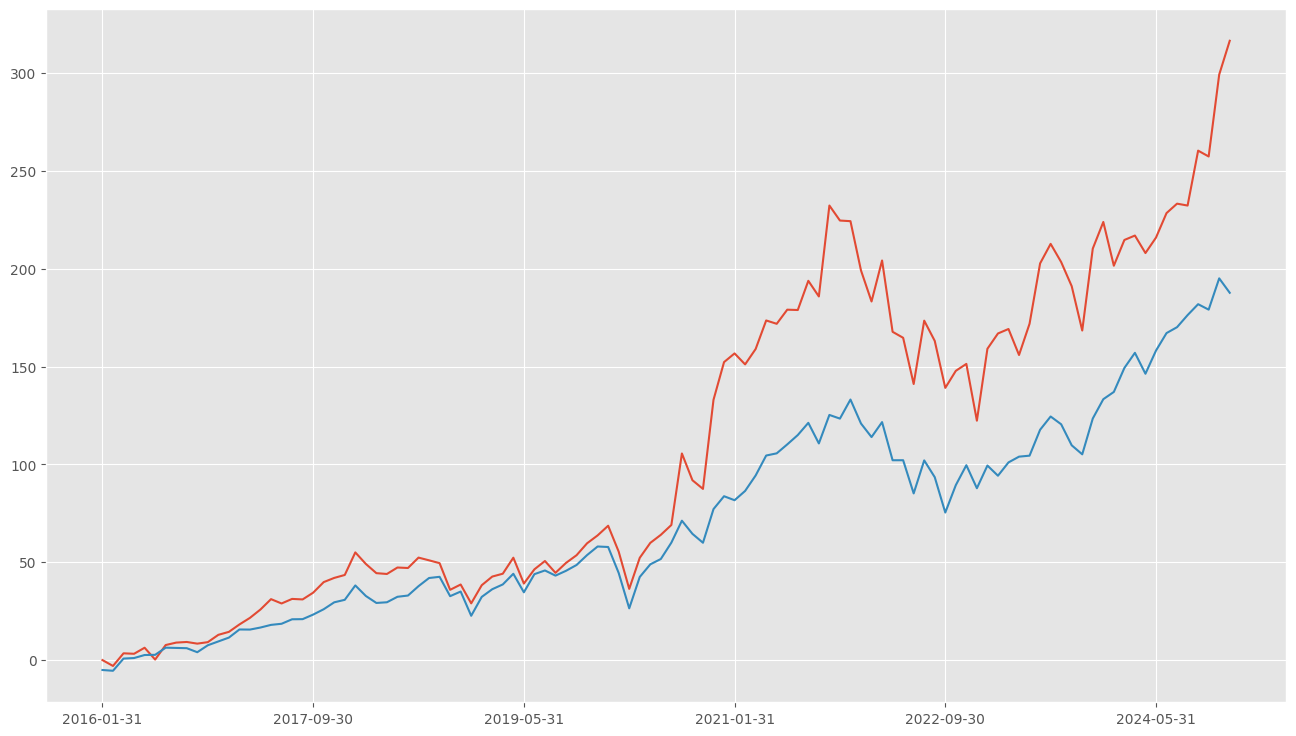

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

fig = plt.figure()

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()